# Data Loading and Quick Look at the Structure

In [23]:
import pandas as pd
import random

random.seed(42)      # We set the random seed to some constant number for reproducible results

train_data = pd.read_csv("../input/vaccine-sentiment-dataset/vaccine_train_set.csv").drop(columns=["Unnamed: 0"])
validation_data = pd.read_csv("../input/vaccine-sentiment-dataset/vaccine_validation_set.csv").drop(columns=["Unnamed: 0"])
test_data = pd.read_csv("../input/vaccine-sentiment-dataset/vaccine_validation_set.csv").drop(columns=["Unnamed: 0"])

In [24]:
train_data.head()    # 0 = Neutral, 1 = Anti-Vax, 2 = Pro-Vax

,tweet,label
0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,I don't know about you but My family and I wil...,1
2,@MSignorile Immunizations should be mandatory....,2
3,President Obama spoke in favor of vaccination ...,0
4,"""@myfoxla: Arizona monitoring hundreds for mea...",0


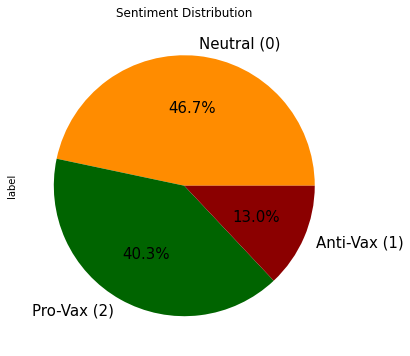

In [25]:
label_sentiments = {0: "Neutral (0)", 1: "Anti-Vax (1)", 2: "Pro-Vax (2)"}   # Make a dictionary mapping each label to its sentiment
plot = train_data['label'].value_counts().rename(index=label_sentiments).plot(kind='pie',figsize=(6,6), fontsize=15, colors=['darkorange','darkgreen','darkred'], title='Sentiment Distribution', autopct='%1.1f%%')

# Data Exploration

Let's see visualize the most frequent words in our training data.

Note: you may need to restart the kernel to use updated packages.


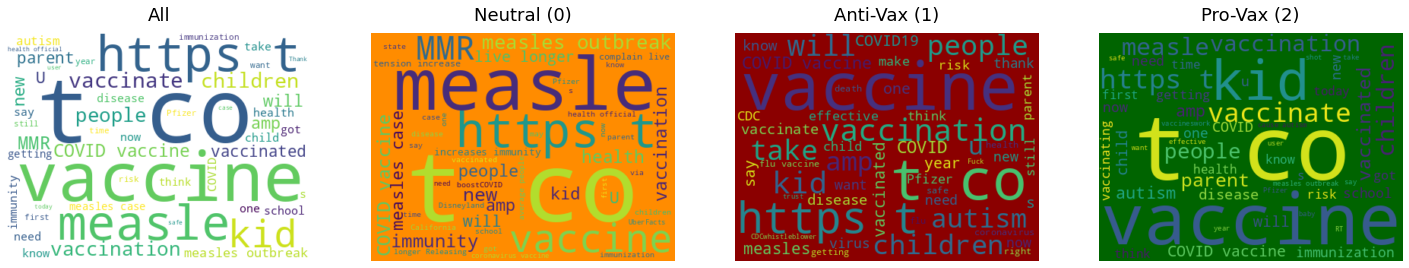

In [26]:
%pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

exploration_data = train_data.copy()    # Get a copy of the training data

all_tweets = " ".join(i for i in exploration_data['tweet'])
neutral_tweets = " ".join(i for i in exploration_data['tweet'][exploration_data['label'] == 0])
negative_tweets = " ".join(i for i in exploration_data['tweet'][exploration_data['label'] == 1])
positive_tweets = " ".join(i for i in exploration_data['tweet'][exploration_data['label'] == 2])

wordcloud_all = WordCloud(max_words=50, height=300, background_color = 'white', stopwords = stopwords).generate(all_tweets)
wordcloud_neutral = WordCloud(max_words=50, height=300, background_color = 'darkorange', stopwords = stopwords).generate(neutral_tweets)
wordcloud_negative = WordCloud(max_words=50, height=300, background_color = 'darkred', stopwords = stopwords).generate(negative_tweets)
wordcloud_positive = WordCloud(max_words=50, height=300, background_color = 'darkgreen', stopwords = stopwords).generate(positive_tweets)

plt.figure(figsize = (25,30))
for i, wordcloud, title in [(1, wordcloud_all, 'All'), (2, wordcloud_neutral, 'Neutral (0)'), (3, wordcloud_negative, 'Anti-Vax (1)'), (4, wordcloud_positive, 'Pro-Vax (2)')]:
    plt.subplot(1,4,i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize = 18, y = 1.03)
    plt.axis("off")
plt.show()

The above visualizations don't look very informative. Firstly, there's a high overlap of individual words between the different categories. This is quite expected considering that even strong words like 'autism' can appear in both Anti-Vax and Pro-Vax tweets as 'vaccines cause autism' and 'vaccines don't cause autism' respectively, hence n-grams like bigrams would probably be much more informative than individual words. Secondly, there's quite some noise in our data, like links (https), that appear too often in our tweets and don't really offer any insights, therefore we'd probably have to clean our data before feeding them to our classification algorithms.

Now let's try to find and visualize the types of noise tweets can possibly have, like:
- tags (@)
- links (http,https,www)
- hashtags (some could be useful though)
- emojis
- emoticons :-)

In [27]:
import re
%pip install emoji
import emoji

def find_urls(tweet):
    """
    Searches for urls (http,https,www) in a tweet .
    """
    url_pattern = re.compile(r'http\S+|www\S+|https\S+')
    return re.search(url_pattern,tweet)

def find_hashtags(tweet):
    """
    Searches for hashtags (#) in a tweet.
    """
    hashtag_pattern = re.compile(r'#(\w+)')
    return re.search(hashtag_pattern,tweet)

def find_tags(tweet):
    """
    Searches for tags (@) in a tweet.
    """
    tag_pattern = re.compile(r'@[^\s]+')
    return re.search(tag_pattern,tweet)

def find_emojis(tweet):
    """
    Searches for emojis in a tweet.
    """
    emoji_pattern = emoji.get_emoji_regexp()
    return re.search(emoji_pattern,tweet)

Note: you may need to restart the kernel to use updated packages.


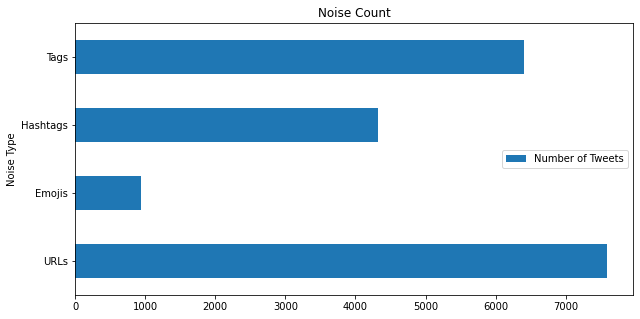

In [28]:
urls = exploration_data['tweet'].apply(find_urls).notnull().sum()
emojis = exploration_data['tweet'].apply(find_emojis).notnull().sum()
hashtags = exploration_data['tweet'].apply(find_hashtags).notnull().sum()
tags = exploration_data['tweet'].apply(find_tags).notnull().sum()
df_noise = pd.DataFrame({'Noise Type': ['URLs', 'Emojis', 'Hashtags', 'Tags'], 'Number of Tweets': [urls, emojis, hashtags,tags]})
df_noise.plot.barh(x='Noise Type', y='Number of Tweets',figsize=(10,5), title='Noise Count');

# Data Preparation

## (Task-Specific) Noise Removal

We create custom transformers for each preparation step in order to create preparation pipelines and later treat our preparation steps as hyperparameters for fine-tuning our best model.

In [29]:
from sklearn.base import BaseEstimator, TransformerMixin

class URLRemover(BaseEstimator, TransformerMixin):
    """
    Removes (or not) the urls from all tweets.
    """
    def __init__(self, strategy='Remove'):
        """
        Available Strategies:
            - Remove: Removes all the urls in all the tweets
            - None: Does nothing. No urls are removed.
        """
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.strategy:
            X_rem = X.copy()
            url_pattern = re.compile(r'http\S+|www\S+|https\S+')
            return X_rem.apply(lambda tweet: url_pattern.sub(r'',tweet))
        return X
    
class HashtagRemover(BaseEstimator, TransformerMixin):
    """
    Removes (or not) the hashtags from all tweets.
    """
    def __init__(self, strategy='Remove'):
        """
        Available Strategies:
            - Remove: Removes all the hashtags in all the tweets.
            - None: Does nothing. No hashtags are removed.
        """
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.strategy:
            X_rem = X.copy()
            hashtag_pattern = re.compile(r'#(\w+)')
            return X_rem.apply(lambda tweet: hashtag_pattern.sub(r'',tweet))
        return X

class TagRemover(BaseEstimator, TransformerMixin):
    """
    Removes (or not) the tags from all tweets.
    """
    def __init__(self, strategy='Remove'):
        """
        Available Strategies:
            - Remove: Removes all the tags in all the tweets.
            - None: Does nothing. No tags are removed.
        """
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.strategy:
            X_rem = X.copy()
            tag_pattern = re.compile(r'@[^\s]+')
            return X_rem.apply(lambda tweet: tag_pattern.sub(r'',tweet))
        return X

class EmojiRemover(BaseEstimator, TransformerMixin):
    """
    Removes (or not) the emojis from all tweets.
    """
    def __init__(self, strategy='Remove'):
        """
        Available Strategies:
            - Remove: Removes all the emojis in all the tweets.
            - Convert: Converts all the emojis to their text representations.
            - None: Does nothing. No emojis are removed.
        """
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.strategy:
            X_rem = X.copy()
            if self.strategy == 'Remove':
                emoji_pattern = emoji.get_emoji_regexp()
                return X_rem.apply(lambda tweet: emoji_pattern.sub(r'',tweet))
            elif self.strategy == 'Convert':
                return X_rem.apply(lambda tweet: emoji.demojize(tweet))
        return X

## Normalization

In [30]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
Stopwords = set(stopwords.words('english')) # We save them in this variable to speed up the lambda function for removing stopwords. It also helps speed up gridSearch later.
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

class LowercaseConverter(BaseEstimator, TransformerMixin):
    """
    Converts (or not) all tweets to lowercase.
    """
    def __init__(self, strategy='Convert'):
        """
        Available Strategies:
            - Convert: Converts all tweets to lowercase.
            - None: Does nothing. No lowercase conversion takes place.
        """
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.strategy:
            return X.str.lower()
        return X      

class PunctuationRemover(BaseEstimator, TransformerMixin):
    """
    Removes (or not) the punctuation from all tweets.
    (In fact, it replaces it with empty space which comes 
    in handy when we convert emojis to their text representations)
    """
    def __init__(self, strategy='Remove'):
        """
        Available Strategies:
            - Remove: Removes all the punctuation in all the tweets.
            - None: Does nothing. No punctuation is removed.
        """
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.strategy:
            X_rem = X.copy()
            punctuation_pattern = re.compile(r'[^\w\s]')
            return X_rem.apply(lambda tweet: punctuation_pattern.sub(r' ',tweet))
        return X
    
class StopwordRemover(BaseEstimator, TransformerMixin):
    """
    Removes (or not) the stopwords from all tweets.
    """
    def __init__(self, strategy='Remove'):
        """
        Available Strategies:
            - Remove: Removes all the stopwords in all the tweets.
            - None: Does nothing. No stopwords are removed.
        """
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.strategy:
            return X.apply(lambda tweet: " ".join([word for word in str(tweet).split() if word not in Stopwords]))
        return X    
    
class InflectedFormHandler(BaseEstimator, TransformerMixin):
    """
    Handles the inflected forms of words by using either Stemming or Lemmatization.
    """
    def __init__(self, strategy='Stemming'):
        """
        Available Strategies:
            - Stemming: Uses a stemmer.
            - Lemmatization: Uses a lemmatizer.
            - None: Does nothing. No inflected form handling takes place.
        """
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.strategy:
            if self.strategy == 'Stemming':
                return X.apply(lambda tweet: " ".join([stemmer.stem(word) for word in tweet.split()]))
            elif self.strategy == 'Lemmatization':
                return X.apply(lambda tweet: " ".join([lemmatizer.lemmatize(word, pos='v') for word in tweet.split()]))
        return X    

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Vectorization

Load and prepare the Word-Embeddings for usage.

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np      

class Vectorizer(BaseEstimator, TransformerMixin):
    """
    Vectorizes the data using Bag of Words, TF-IDF or Pre-Trained Word-Embeddings.
    """
    def __init__(self, strategy='BoW', ngram_range=(1,1), min_df=1, max_df=1.0, dimensions=None):
        """
        Available Strategies:
            - BoW: Bag of Words.
            - TF-IDF: TF-IDF,
            - Word-Embeddings: Pre-trained GloVe Twitter Word Embeddings.
        ngram_range: the ngram_range parameter e.g. ngrams=(1, 1)=only unigrams, (1, 2)=unigrams and bigrams
        min_df: minimum number of tweets a word must be present in to be considered a feature
        max_df: maximum number of tweets a word can be present in to be considered a feature
        dimensions: 25 or 50 or 100 or 200, depending on how many dimensions (i.e. which file) to use for the word-embeddings
        """
        self.strategy = strategy
        self.ngram_range = ngram_range
        self.min_df = min_df
        self.max_df = max_df
        self.vectorizer = None                  # Used only when strategy is either BoW or TF-IDF
        self.dimensions = dimensions
    def fit(self, X, y=None):
        """
        Initiates the vectorizer to the chosen method (bow or tfidf) and then only fits the vectorizer 
        on the data (no transform). This way we can 'fit_transform' on the training data and only call 
        'transform' on the validation data.
        """
        if self.strategy == 'BoW':
            self.vectorizer = CountVectorizer(analyzer='word', ngram_range=self.ngram_range, min_df=self.min_df, max_df=self.max_df)
            self.vectorizer.fit(X)
        elif self.strategy == 'TF-IDF':
            self.vectorizer = TfidfVectorizer(analyzer='word', ngram_range=self.ngram_range, min_df=self.min_df, max_df=self.max_df)
            self.vectorizer.fit(X)
        # If strategy is 'Word-Embeddings', we don't do anything during 'fit'
        return self
    def transform(self, X):
        """
        Transforms the data using the -already fit- vectorizer of the class.
        """
        X_vec = X.copy()
        if self.strategy == 'BoW' or self.strategy == 'TF-IDF':
            X_vec =  self.vectorizer.transform(X_vec)
        else:
            # Initialize the all vectorized tweets to zeros
            X_vec = np.zeros((len(X),self.dimensions))
            # For each tweet in the dataset
            for index, tweet in enumerate(X):
                valid_words_num = 0                                                         # Number of words in this tweet that are in GloVe's vocabulary
                word_vectors = np.zeros(self.dimensions)
                # For each word in this particular tweet
                for word in tweet.split():
                    # If the word is the GloVe's vocabulary
                    if word in all_embeddings_dict[self.dimensions].keys():
                        valid_words_num += 1
                        # Add this word's vector to the whole tweet's vector (Vertically)
                        word_vectors = np.vstack((word_vectors,all_embeddings_dict[self.dimensions][word])) if valid_words_num > 1 else all_embeddings_dict[self.dimensions][word]
                # Get the mean over the 0 axis (i.e. one value per dimension)
                X_vec[index] = word_vectors.mean(axis=0) if valid_words_num > 1 else word_vectors
        return X_vec

# Fine-Tuning BERT

The Neural Network

In [32]:
!pip install transformers
import torch
import torch.nn as nn
from transformers import BertModel

class BertCLS(nn.Module):
    """
    Bert Model for Classification Tasks.
    """
    def __init__(self, INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT):
        super(BertCLS, self).__init__()
        
        # Save input, hidden, output dimensions and the dropout probability
        self.INPUT_DIM = INPUT_DIM 
        self.HIDDEN_DIM = HIDDEN_DIM 
        self.OUTPUT_DIM = OUTPUT_DIM
        self.DROPOUT = DROPOUT

        # Instantiate the BERT model
        self.Bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(INPUT_DIM, HIDDEN_DIM),
            nn.ReLU(),
            nn.Dropout(DROPOUT),
            nn.Linear(HIDDEN_DIM, OUTPUT_DIM)
        )

        # Softmax activation function layer
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_ids, attention_mask):
        # Feed the input_ids to BERT
        outputs = self.Bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return self.softmax(logits)

Train/Validation Loops

In [33]:
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

def train_loop(dataloader, model, loss_fn, optimizer, device, clip_value=1):
    """
    Performs a -single- training iteration (epoch) of the network over all the batches. That is, it performs a forward propagation, 
    computes the error, computes the metric scores (e.g. f1, precision etc) -over the training dataset- for later plotting and then
    updates the parameters using backpropagation. The update takes place per batch. The function returns the (avg. over the batches) 
    scores for each of the metrics on the validation dataset.
    """
    num_batches, sum_losses, sum_f1s, sum_precisions, sum_recalls = (len(dataloader),0,0,0,0)
    model.train()
    for step,batch in enumerate(dataloader):
        # Transfer tensors to the specified device
        X, attention_mask, y = tuple(t.to(device) for t in batch)

        # Clear gradients
        optimizer.zero_grad()

        # Compute prediction and loss
        pred = model(X, attention_mask)
        loss = loss_fn(pred,y)

        # Compute metric scores
        sum_losses += loss.item()
        sum_f1s += f1_score(y.cpu().numpy(), pred.argmax(1).cpu().numpy(), average='weighted', zero_division=0)
        sum_precisions += precision_score(y.cpu().numpy(), pred.argmax(1).cpu().numpy(), average='weighted', zero_division=0)
        sum_recalls += f1_score(y.cpu().numpy(), pred.argmax(1).cpu().numpy(), average='weighted', zero_division=0)

        # Backpropagation
        loss.backward()
        if clip_value:
            torch.nn.utils.clip_grad_value_(model.parameters(), clip_value)
        optimizer.step()

    return sum_losses/num_batches, sum_f1s/num_batches, sum_precisions/num_batches, sum_recalls/num_batches

def validation_loop(dataloader, model, loss_fn, device):
    """
    Performs a -single- validation iteration (epoch) of the network over all the batches. That is, it performs a forward propagation
    to make the predictions and compute the metric scores -over the validation dataset- for later plotting. We don't update any parameters
    because there's no training taking place, only prediction, to evaluate our model after each epoch. The predictions also take place per
    batch. The function returns the (avg. over the batches) scores for each of the metrics on the validation dataset.
    """
    num_batches, sum_losses, sum_f1s, sum_precisions, sum_recalls = (len(dataloader),0,0,0,0)
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            # Transfer tensors to the specified device
            X, attention_mask, y = tuple(t.to(device) for t in batch)
            
            # Compute prediction
            pred = model(X, attention_mask)

            # Compute metric scores
            sum_losses += loss_fn(pred,y).item()
            sum_f1s += f1_score(y.cpu().numpy(), pred.argmax(1).cpu().numpy(), average='weighted', zero_division=0)
            sum_precisions += precision_score(y.cpu().numpy(), pred.argmax(1).cpu().numpy(), average='weighted', zero_division=0)
            sum_recalls += recall_score(y.cpu().numpy(), pred.argmax(1).cpu().numpy(), average='weighted', zero_division=0)

    return sum_losses/num_batches, sum_f1s/num_batches, sum_precisions/num_batches, sum_recalls/num_batches

def train_evaluate_network(train_dataloader, validation_dataloader, model, loss_func, optimizer, epochs, device, clip_value):
    """
    Performs the training of the network and evaluation of it over each epoch. For each epoch, it first performs a train_loop to update
    its parameters and then evaluates the network by performing a validation loop. For each epoch, it saves the metric scores for each
    dataset its corresponding dictionary and metric list. The function returns the train_scores and validation_scores per epoch for
    later plotting.
    """
    train_scores = {'loss':[], 'f1':[], 'precision':[], 'recall':[]}
    validation_scores = {'loss':[], 'f1':[], 'precision':[], 'recall':[]}
    for t in range(epochs):
        # Update the network's parameters
        train_loss, train_f1, train_precision, train_recall = train_loop(train_dataloader, model, loss_func, optimizer, device, clip_value)

        # Evaluate the updated model on the validation set 
        validation_loss, validation_f1, validation_precision, validation_recall = validation_loop(validation_dataloader, model, loss_func, device)

        # Save the training scores of this epoch
        train_scores['loss'].append(train_loss)
        train_scores['f1'].append(train_f1)
        train_scores['precision'].append(train_precision)
        train_scores['recall'].append(train_recall)
        
        # Save the validation scores of this epoch
        validation_scores['loss'].append(validation_loss)
        validation_scores['f1'].append(validation_f1)
        validation_scores['precision'].append(validation_precision)
        validation_scores['recall'].append(validation_recall)

    return train_scores, validation_scores

def plot_scores(train_scores,validation_scores,epochs,title):
    """
    Plots the training and validation scores per epoch. That is, the loss (as specified by the loss function used during training) over the
    epochs, the f1 scores over the epochs, the precision over the epochs and the recall over the epochs, for each of the two datasets. 
    """
    plt.figure(figsize = (20,4))
    for i,metric in enumerate(['loss','f1','precision','recall']):
        plt.subplot(1,4,i+1)
        plt.plot(range(1,epochs+1), train_scores[f'{metric}'], label = 'Training')
        plt.plot(range(1,epochs+1), validation_scores[f'{metric}'], label = 'Validation')
        plt.ylabel(f'{metric}', fontsize = 12)
        plt.xlabel('epoch', fontsize = 12)
        plt.title(f'{metric} over epochs', fontsize = 12, y = 1.03)
        plt.legend()
    plt.suptitle(title,fontsize=12)
    plt.tight_layout()

Prepare the Data

In [34]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer
from sklearn.pipeline import Pipeline
from torchtext.legacy import data
from torchtext.vocab import GloVe
import random

# For reproducible results
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Preprocessing pipeline
preparation_pipeline = Pipeline([
        ('urls', URLRemover()),
        ('hashtags', HashtagRemover()),
        ('tags', TagRemover()),
        ('emojis', EmojiRemover(strategy='Remove')),
        ('lowercase', LowercaseConverter()),
        ('punctuation', PunctuationRemover()),
        ('stopwords', StopwordRemover(strategy=None)),
        ('inflected_forms', InflectedFormHandler(strategy='Lemmatization'))
    ])

# Copy the data
X_train = train_data.copy()['tweet']
y_train = train_data.copy()['label']
X_validation = validation_data.copy()['tweet']
y_validation = validation_data.copy()['label']     
X_test = test_data.copy()['tweet']
y_test = test_data.copy()['label']

# Preprocess the data
X_train = preparation_pipeline.fit_transform(X_train)
X_validation = preparation_pipeline.transform(X_validation)
X_test = preparation_pipeline.transform(X_test)

# Remove the ones that got empty after preprocessing
full_train = pd.merge(X_train, y_train, right_index = True, left_index = True)                   # Holds both the tweets and the labels
full_validation = pd.merge(X_validation, y_validation, right_index = True, left_index = True)
full_test = pd.merge(X_test, y_test, right_index = True, left_index = True)

empty_train_indices = [i for i, train_instance in full_train.iterrows() if len(train_instance['tweet']) == 0]
empty_validation_indices = [i for i, validation_instance in full_validation.iterrows() if len(validation_instance['tweet']) == 0]
empty_test_indices = [i for i, test_instance in full_test.iterrows() if len(test_instance['tweet']) == 0]

full_train.drop(full_train.index[empty_train_indices], inplace=True)
full_validation.drop(full_validation.index[empty_validation_indices], inplace=True)
full_test.drop(full_test.index[empty_test_indices], inplace=True)

# Split the data again into X and y
X_train = full_train.copy()['tweet']
y_train = full_train.copy()['label']
X_validation = full_validation.copy()['tweet']
y_validation = full_validation.copy()['label']     
X_test = full_test.copy()['tweet']
y_test = full_test.copy()['label']

# BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def get_max_len(X_train,X_validation):
    all_X = np.concatenate([X_train.values, X_validation.values])
    encoded = [bert_tokenizer.encode(sentence, add_special_tokens=True) for sentence in all_X]
    MAX_LEN = max([len(sentence) for sentence in encoded])
    print('Max length: ', MAX_LEN)
    return MAX_LEN

MAX_LEN = get_max_len(X_train,X_validation)

def bert_preprocess(data):
    input_ids = []
    attention_masks = []

    for sentence in data:
        encoded_sentence = bert_tokenizer.encode_plus(
            text=sentence,                               # Sentence
            add_special_tokens=True,                     # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                          # Max length to truncate/pad
            pad_to_max_length=True,                      # Pad sentence to max length
            return_attention_mask=True                   # Return attention mask
        )
        input_ids.append(encoded_sentence.get('input_ids'))
        attention_masks.append(encoded_sentence.get('attention_mask'))

    # Convert to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

# Bert preprocesing
train_inputs, train_masks = bert_preprocess(X_train)
validation_inputs, validation_masks = bert_preprocess(X_validation)
test_inputs, test_masks = bert_preprocess(X_test)

# Convert labels to tensors
train_labels = torch.tensor(y_train.to_numpy())
validation_labels = torch.tensor(y_validation.to_numpy())
test_labels = torch.tensor(y_test.to_numpy())

# Set Batch Size
batch_size = 16

# DataLoader for the training set
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

# DataLoader for the validation set
validation_dataset = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_dataset)
validation_dataloader = DataLoader(validation_dataset, sampler=validation_sampler, batch_size=batch_size)

# DataLoader for the test set
test_dataset = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Max length:  101


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train the Model

Device name: Tesla P100-PCIE-16GB


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CPU times: user 7min 33s, sys: 1min 33s, total: 9min 6s
Wall time: 9min 9s


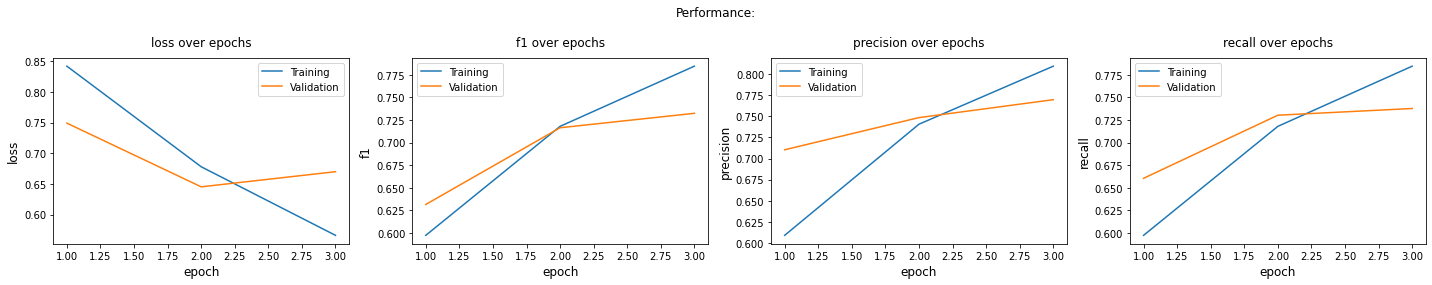

In [35]:
%%time
from transformers import AdamW, get_linear_schedule_with_warmup

# Set up GPU for training
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print('Device name:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")

# Hyperparameters
INPUT_DIM = 768
HIDDEN_DIM = 32
OUTPUT_DIM = 3
DROPOUT = 0.7                                                             # Dropout Probability
GRAD_CLIP_VALUE = 1.0                                                     # Gradient Clipping Value

# Model Definition and move to GPU
bert_classifier = BertCLS(INPUT_DIM,HIDDEN_DIM,OUTPUT_DIM,DROPOUT)
bert_classifier.to(device)

# Optimizer Definition
optimizer = AdamW(bert_classifier.parameters(), lr=5e-5, eps=1e-8)

# Loss Function Definition and move to GPU
loss_func = nn.NLLLoss().to(device)

epochs = 3
train_scores, validation_scores = train_evaluate_network(train_dataloader, validation_dataloader, bert_classifier, loss_func, optimizer, epochs, device, GRAD_CLIP_VALUE)

plot_scores(train_scores,validation_scores,epochs,f'Performance:')

# Error Analysis (Evaluation of Best Model on the -Validation- Set)

In [36]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns

def plot_confusion_matrix(y_validation,predictions_validation):
    normalized_confusion_matrix = confusion_matrix(y_validation, predictions_validation) / confusion_matrix(y_validation, predictions_validation).sum(axis=1, keepdims=True)
    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(normalized_confusion_matrix, annot=True, cmap=plt.cm.gray, xticklabels=label_sentiments.values(), yticklabels=label_sentiments.values())
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Validation Confusion Matrix')
    plt.show()
    
def print_wrong_examples(y_validation,predictions_validation):
    normalized_confusion_matrix = confusion_matrix(y_validation, predictions_validation) / confusion_matrix(y_validation, predictions_validation).sum(axis=1, keepdims=True)
    print("Examples of Wrong Classification in Validation:\n")
    for actual in label_sentiments.keys():
      for predicted in label_sentiments.keys():
        if actual != predicted and normalized_confusion_matrix[actual, predicted] > 0.2:       # Print only examples of label pairs with >20% confusion rate in the matrix
            print(f"\n'{label_sentiments[actual]}' Predicted as '{label_sentiments[predicted]}' - {round(100*normalized_confusion_matrix[actual, predicted])}% Confusion Rate:\n")
            for index,row in validation_data.loc[(y_validation == actual) & (predictions_validation == predicted)].head().iterrows():
                print(f"Index: {index} - Tweet: {row['tweet']}")
                
def print_top_ngrams(preparation_pipeline, model, N=6):         
    """
    Prints the most top N most correlated n-grams for each of the labels.
    (according to the learned θ parameters of the classification model)
    preparation_pipeline = The pipeline used to preprocess the data
                          (we need this for the ngrams used and the
                          feature_names of the vectorizer)
    model = This is the softmax regression model whose θ parameters we use
            to find the top n-grams
    N = The number of top n-grams to print e.g. the top 6 uni-grams and bi-grams
    """
    vectorizer = preparation_pipeline['vectorization'].vectorizer          # Get the vectorizer instance from the pipeline
    ngram_range = preparation_pipeline['vectorization'].ngram_range        # Get the value of the ngrams parameter in pipeline's vectorizer
    for label in label_sentiments.keys():
        indices = np.argsort(model.coef_[label])                           # Sort the model's learned coefficients θ (for each label) from lowest to highest and get their -indices-
        feature_names = np.array(vectorizer.get_feature_names())[indices]  # Get the words themselves (from the chosen vectorizer) corresponding to each index/coefficient
        print(f"\nIn '{label_sentiments[label]}' Tweets:")
        for n in range(ngram_range[0],ngram_range[1]+1):                   # Convert the ngram_range tuple to a range of numbers e.g. (1,3) = 1,2,3
            n_grams = [v for v in reversed(feature_names) if len(v.split(' ')) == n][:N]
            print("  Top {}-grams:\n      - {}".format(n,'\n      - '.join(n_grams))) 

def plot_roc_curve(y_validation,predictions_validation_probabilities):
    # Binarize the output
    y_true = label_binarize(y_validation, classes=[0, 1, 2])
    n_classes = y_true.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    lw=2
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], predictions_validation_probabilities.cpu().numpy()[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

Predict on the validation set and do some error analysis

In [37]:
predictions_validation_probabilities = torch.empty((batch_size,3),dtype=torch.float).to(device)

bert_classifier.eval()
with torch.no_grad():
    for i,batch in enumerate(validation_dataloader):
        # Transfer tensors to the specified device
        X, attention_mask, y = tuple(t.to(device) for t in batch)
        if i == 0:
            predictions_validation_probabilities = bert_classifier(X, attention_mask)
        else:
            predictions_validation_probabilities = torch.cat((predictions_validation_probabilities,bert_classifier(X, attention_mask)))
predictions_validation = predictions_validation_probabilities.argmax(1).cpu().numpy()

In [38]:
print(classification_report(y_validation, predictions_validation))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79      1063
           1       0.67      0.43      0.52       294
           2       0.68      0.80      0.73       920

    accuracy                           0.74      2277
   macro avg       0.72      0.67      0.68      2277
weighted avg       0.74      0.74      0.73      2277



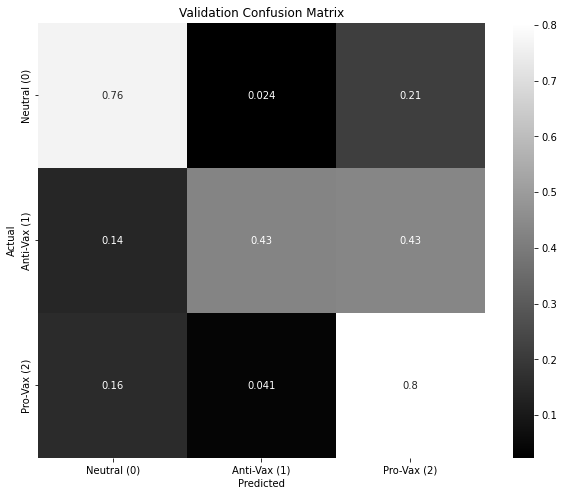

In [39]:
plot_confusion_matrix(y_validation, predictions_validation)

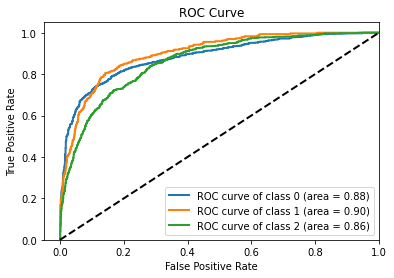

In [40]:
plot_roc_curve(y_validation,predictions_validation_probabilities)

# Final Model Evaluation on the Test Set

Predict on the test data

In [41]:
predictions_test_probabilities = torch.empty((batch_size,3),dtype=torch.float).to(device)

bert_classifier.eval()
with torch.no_grad():
    for i,batch in enumerate(test_dataloader):
        # Transfer tensors to the specified device
        X, attention_mask, y = tuple(t.to(device) for t in batch)
        if i == 0:
            predictions_test_probabilities = bert_classifier(X, attention_mask)
        else:
            predictions_test_probabilities = torch.cat((predictions_test_probabilities,bert_classifier(X, attention_mask)))
predictions_test = predictions_test_probabilities.argmax(1).cpu().numpy()

In [42]:
print(classification_report(y_test, predictions_test))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79      1063
           1       0.67      0.43      0.52       294
           2       0.68      0.80      0.73       920

    accuracy                           0.74      2277
   macro avg       0.72      0.67      0.68      2277
weighted avg       0.74      0.74      0.73      2277



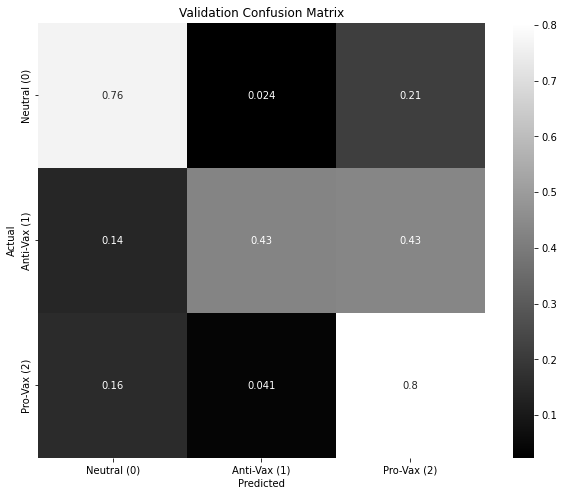

In [43]:
plot_confusion_matrix(y_test,predictions_test)

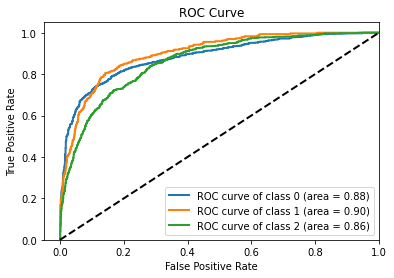

In [44]:
plot_roc_curve(y_test,predictions_test_probabilities)

# References

https://towardsdatascience.com/what-exactly-happens-when-we-fine-tune-bert-f5dc32885d76

https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03

https://www.tensorflow.org/text/tutorials/fine_tune_bert

https://medium.com/@erik.terres.es/fine-tuning-bert-for-sentiment-analysis-on-non-labeled-twitter-data-1fd8951fbbd4

https://mccormickml.com/2019/07/22/BERT-fine-tuning/

https://pysnacks.com/bert-text-classification-with-fine-tuning/#multi-class-text-classification-using-bert

https://skimai.com/fine-tuning-bert-for-sentiment-analysis/